In [42]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from scipy.optimize import minimize

from neurodsp.sim import sim_random_walk
from neurodsp.sim.transients import sim_synaptic_kernel


In [2]:
# signal params
FS = 1000 # sampling rate (Hz)
N_SECONDS = 1 # signal length (s)

# spiking params
N_NEURONS = 5
FIRING_RATE = 20 # average rate of each neuron (Hz)

# random process params
ALPHA = 1.
TAU_C = 1.0E-2

In [32]:
def autocorr(x, maxlag):
    xcorr = np.correlate(x - x.mean(), x - x.mean(), 'full')  # Compute the autocorrelation
    xcorr = xcorr / xcorr.max()                               # Convert to correlation coefficients
    xcorr = xcorr[int(xcorr.size//2-maxlag-1) : int(xcorr.size//2+maxlag+1)]# Return only requested lags
    return xcorr                                     
    

def plot_correlations(spikes, plot_model=False, maxlags=20, tau_c=1, alpha=1,
                     plot_all=False):
    n_neurons = spikes.shape[0]
    fig, ax = plt.subplots(nrows=n_neurons, ncols=n_neurons, figsize=(14,14), sharey=True)
    for i_row in range(n_neurons):
        for i_col in range(n_neurons):
            # plot bottom triangle only
            if (not plot_all) & (i_col > i_row): continue
                    
            # plot correlation
            ax[i_row, i_col].xcorr(spikes[i_row].astype(float), spikes[i_col].astype(float), maxlags=maxlags)
            
            if plot_model:
                t = np.arange(-maxlags,maxlags)
                cross_covar = alpha * np.exp(-abs(t)/(tau_c * 1000))
                ax[i_row, i_col].plot(t, cross_covar)
      
    return fig, ax

def model_acorr(lags, alpha, tau_c):
    model = alpha * np.exp(-np.abs(lags)/(tau_c))
    
    return model

def calc_model_error(tau_c, alpha, empirical, lags):
    # comput model
    model = model_acorr(lags, alpha, tau_c)
    
    # calc error
    error = np.sum(np.abs(empirical - model))
    
    return error


In [7]:
# 1. Generate N independent Ornstein-Uhlenbeck processes

rand_process = np.zeros([N_NEURONS, N_SECONDS*FS])
for i_neuron in range(N_NEURONS):
    rand_process[i_neuron] = sim_random_walk(N_SECONDS, FS, mu=0, sigma=(2*TAU_C*ALPHA)**0.5, theta=1/TAU_C)
    

[[0.99294188 0.55064786 0.74601925 0.46584549 0.44137653]
 [0.55064786 0.99294188 0.45179691 0.55840889 0.43634213]
 [0.74601925 0.45179691 0.99294188 0.50849979 0.58394756]
 [0.46584549 0.55840889 0.50849979 0.99294188 0.9724732 ]
 [0.44137653 0.43634213 0.58394756 0.9724732  0.99294188]]


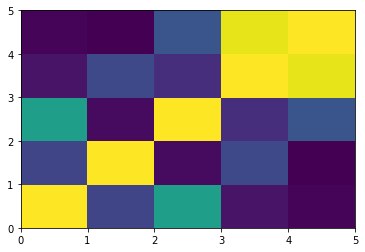

In [25]:
# 2. Compute L from the Cholesky decomposition of C = LLT

# define correlation matrix
# create matrix C
# set C_i,j to random value between 0 and 1
c_star = np.zeros((N_NEURONS,N_NEURONS))
for i in range(c_star.shape[0]):
    for j in range(c_star.shape[1]):
        if j < i:
            rand_num = np.random.uniform(low=0.2)
            c_star[i,j] = rand_num
            c_star[j,i] = rand_num

# create matrix D
big_d = np.zeros((N_NEURONS,N_NEURONS))
np.fill_diagonal(big_d, FIRING_RATE**2)

# solve or alpha
# create matrix D**-1
d_inv = np.zeros((N_NEURONS,N_NEURONS))
np.fill_diagonal(d_inv, 1/FIRING_RATE**2)
# find small real-valued eigenvalue
temp = np.dot(d_inv, c_star)
eig, _ = linalg.eig(temp)
alpha_corr = - np.real(np.min(eig[np.isreal(eig)]))

# create matrix C_alpha
c_alpha = c_star + (alpha_corr * big_d)

# print results
corr_mat = c_alpha
print(corr_mat)
plt.pcolor(corr_mat)


22.088625542002635
3.1689037425971143


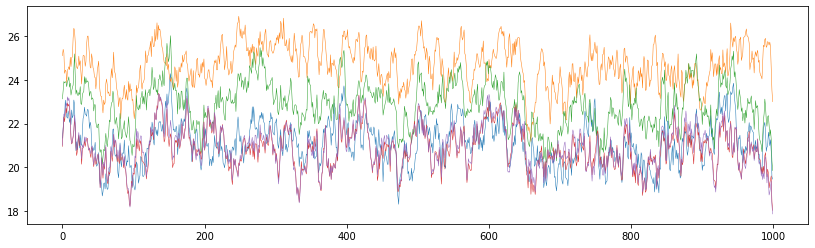

In [30]:
# 3. Let X = R + LY

# compute cholesky
l_chol = linalg.cholesky(corr_mat).T

# dot random process and root correlation
LY = np.dot(l_chol, rand_process)

# compute firing rate
f_rate = FIRING_RATE + np.random.rand(5) * 5
firing_rate = f_rate[:, np.newaxis] + LY
# firing_rate = LY
firing_rate[firing_rate < 0] = 0

# turn rates into spikes
for j_bin in range(len(firing_rate)):
    for i_neuron in range(N_NEURONS):
        if firing_rate[i_neuron, j_bin] / FS > np.random.uniform():
            spikes[i_neuron, j_bin] = 1
            
# display results
fig, ax = plt.subplots(figsize=[14,4])
plt.plot(firing_rate.T, linewidth=0.5);
print(np.mean(firing_rate))
print(np.std(firing_rate)**2)

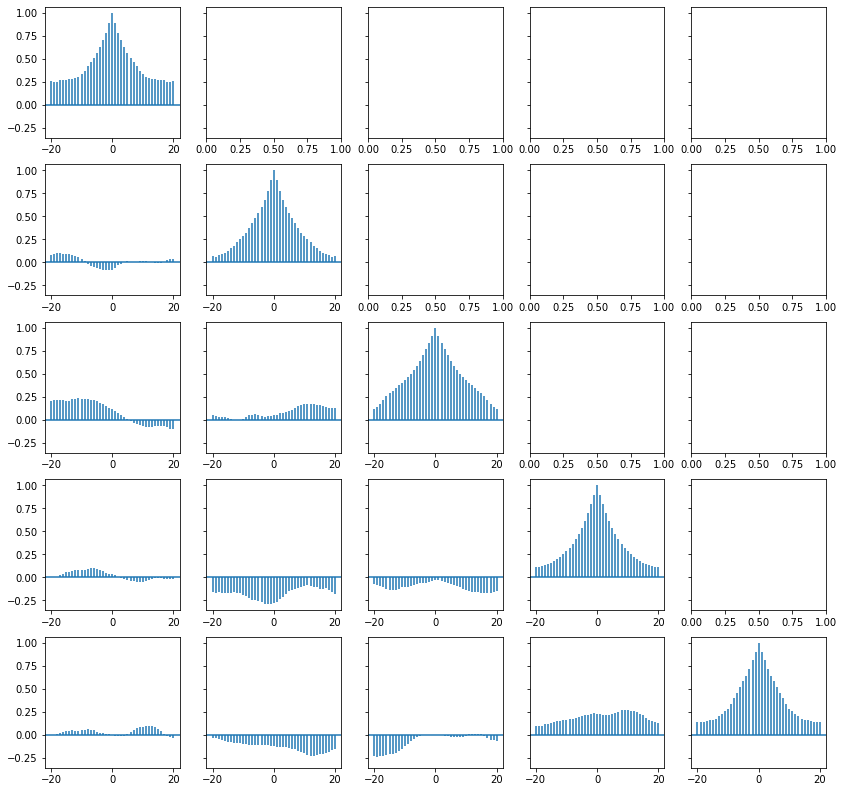

In [33]:
plot_correlations(rand_process, maxlags=20, plot_model=False);

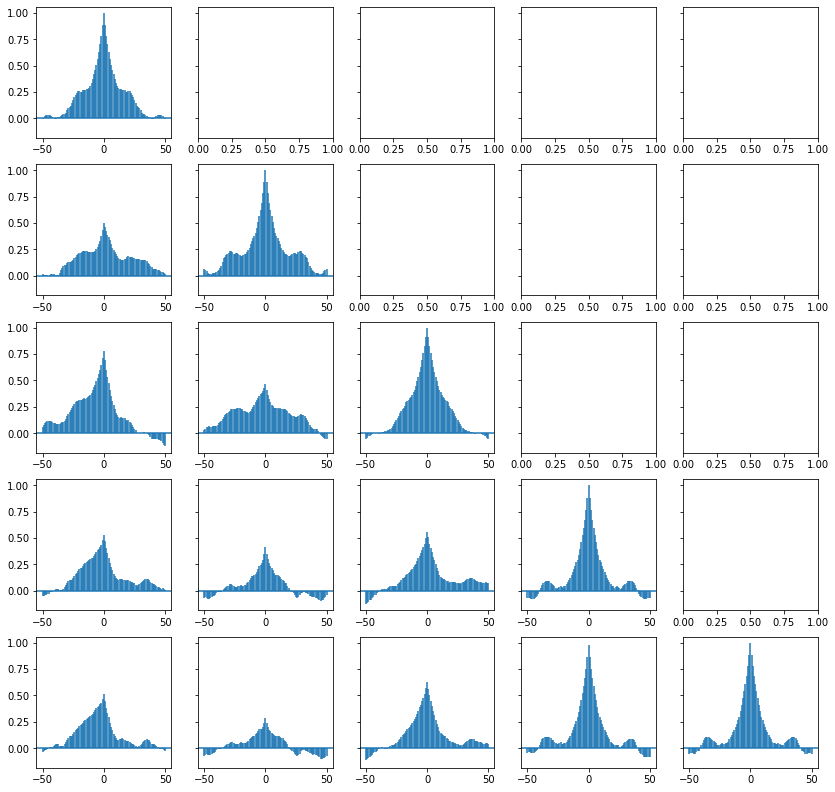

In [34]:
plot_correlations(firing_rate-np.mean(firing_rate,1)[:,np.newaxis], maxlags=50, plot_model=False);

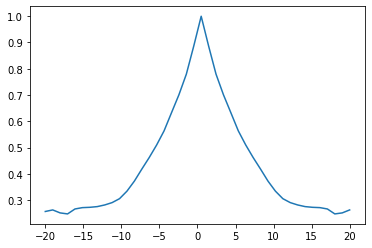

In [40]:
# autocorrelationof population firing rate

# choose example to plot
EXAMPLE = 0

# calc autocorr
max_lags = int(FS*.02)
acorr = autocorr(firing_rate[EXAMPLE], max_lags)

# plot autocorr
t_vector = np.linspace(-max_lags, max_lags, len(acorr_pop))
fig, ax = plt.subplots()
ax.plot(t_vector, acorr_pop)


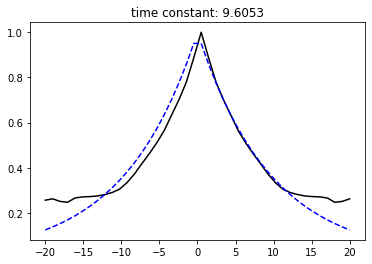

In [43]:
# solve for time constant
x0 = 1
result = minimize(calc_model_error, x0=x0, args=(1, acorr, t_vector))
tau_c_fit = result['x']

# show results
model = model_acorr(t_vector, 1, tau_c_fit)
fig, ax = plt.subplots()
ax.plot(t_vector, acorr_pop, color='k')
ax.plot(t_vector, model, color='b', linestyle='--')
ax.set_title('time constant: %0.4f' %tau_c_fit);